# SETTINGS

## Importamos Librerías

In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
import json
import os
print(os.getcwd())
# spacy.__version__
# Check GPU information
# !nvidia-smi

C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner


## Creamos una carpeta para entrenar el modelo

In [15]:
def generate_model_folder(base_folder='textcat_model_', start_index=1):
    index = start_index
    while True:
        folder_name = f"{base_folder}{index}"
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
            ner_model_path = os.path.abspath(folder_name)

            yield folder_name,ner_model_path
        index += 1

# Invocamos al generador
folder_generator = generate_model_folder()

# Get the next available folder
model_folder, model_path = next(folder_generator)

print(f"Created folder: {model_folder}")
print(f'new path is : {model_path}')

Created folder: textcat_model_1
new path is : C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner\textcat_model_1


## levantamos los datos y los guardamos con formato spacy en la carpeta del modelo

In [10]:
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import string
from unidecode import unidecode
import os

In [7]:
path = r'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner'

anotados = pd.read_pickle(os.path.join(path,'anotados.pkl'))

In [11]:
# Load the spaCy model for Spanish
nlp = spacy.load('es_core_news_sm')

def preprocess(text):
    # Step 1: Lowercasing
    text = text.lower()
    text = unidecode(text)
    
    # Step 2: Tokenization
    doc = nlp(text)

    # Step 3: Stopword removal
    # tokens = [token.text for token in doc if token.text not in STOP_WORDS]
    #tokens = [token.text for token in doc if token.text not in STOP_WORDS and token.text not in string.punctuation]
    
    # Step 4: Lemmatization
    #lemmatized_tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS]
    lemmatized_tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS and token.text not in string.punctuation]


    return " ".join(lemmatized_tokens)

# Example usage:
text_example = "Este es un ejemplo de ,texto en español que queremos procesar."
preprocessed_tokens = preprocess(text_example)

print("Original Text:", text_example)
print("Preprocessed Tokens:", preprocessed_tokens)

Original Text: Este es un ejemplo de ,texto en español que queremos procesar.
Preprocessed Tokens: ejemplo texto espanol procesar


In [12]:
anotados['tokens'] = [preprocess(l) for l in anotados['Letters'] ]
anotados = anotados[['Letters', 'tokens', 'Numbers']]
anotados.head()

,Letters,tokens,Numbers
0,\nFLORIAN S.A.\n1) Daniel Mario Marquez DNI 10...,\n floriar s.a \n 1 daniel mario marquez dni 1...,1
1,\nSOLUCIONES DE SEGURIDAD VIAL S.A.\nPor Asamb...,\n solución seguridad vial s.a \n asamblea gen...,0
2,\nAVAPYME S.A.S.\nCONSTITUCIÓN: 17/10/2018. 1....,\n avapymir s.a.s \n constitucion 17/10/2018 1...,1
3,\nSHABBA FARMA S.R.L.\nEsc. 269 del 29-3-22 Re...,\n shabba farmar s.r.l \n esc 269 29-3-22 regi...,1
4,\nGADA GROUP S.A.\nCUIT 30-71583994-2. Por Act...,\n gado group s.a \n cuit 30-71583994-2 acta a...,0


In [13]:
texts = anotados['tokens'].values
# train_labels = [{'cats': label}  for label in anotados['Numbers']]
labels = anotados['Numbers'].values

data = list(zip(texts, labels))
data[0]

('\n floriar s.a \n 1 daniel mario marquez dni 10788314 argentino divorciado comerciante 23/02/53 guillermo rawson 2715 \n localidad olivo partido vicente lopez pcia bs as suscribir 95 acción alberto rivera luna dni \n 18820133 argentino divorciado comerciante 06/01/68 av cobir 1581 car suscribir 5 acción \n nominativa endosabl 4000 valor nominal 1 voto accion 2 10/02/22 4 junin 1715 car \n 5 restaurante cafe bar salon evento 6 30 ano 7 400000 8) direccion administracion 1 7 director \n 3 ejercicio sindico 9 presidente presidente daniel mario marquez vicepresidente alberto rivera \n luna suplente gustavo marcelo graieb dni 14157635 argentino soltero productor seguro 14/05/60 av \n cabildo 1695 piso 8 depto 26 car domicilio especial sede social 10 30/06 autorizado \n instrumento publico esc 16 fecha 10/02/2022 reg 412 \n pablo damiar rodriguez tdeg 69 fdeg 84 c.p.a.c.f \n',
 1)

In [14]:
# Split the annotated data into training and testing sets
from sklearn.model_selection import train_test_split
training, dev = train_test_split(data, test_size=0.1, random_state=42)
train, test = train_test_split(training, test_size=0.2, random_state=42)

# Display the number of items in the training and testing sets
len(train), len(test), len(dev)

(504, 126, 70)

In [21]:
from spacy.tokens import DocBin
import spacy


def convert(data, outfile):
    # spacy_model = 'es_core_news_sm'
    nlp = spacy.load("es_core_news_sm")  # es_core_news_sm /  es_dep_news_trf
    db = spacy.tokens.DocBin()
    docs = []
    for doc, label in nlp.pipe(data, as_tuples=True):
        doc.cats["POS"] = label == 1
        doc.cats["NEG"] = label == 0
        db.add(doc)
    
    db.to_disk(outfile)
file = open(os.path.join(model_path,'train_file.txt'),'w')

convert(train, os.path.join(model_path,'train.spacy'))
convert(test, os.path.join(model_path,'test.spacy'))
convert(dev, os.path.join(model_path,'dev.spacy'))

file.close()

In [24]:
os.listdir(model_path)

['dev.spacy', 'test.spacy', 'train.spacy', 'train_file.txt']

## generamos el archivo config.cfg

Generamos el archivo base_config y lo dejamos en la carpeta nueva que creamos.

https://spacy.io/usage/training

In [27]:
def generate_spacy_init_command(base_path, config_filename = "config.cfg"):
    """
    Generate a string for running the 'spacy init fill-config' command.

    Args:
    - base_path (str): The base path where the files are located.
    - config_filename (str): The name of the configuration file.

    Returns:
    - str: The generated command string.
    """
    if base_path is None:
        
        base_path = os.getcwd()
        
    command = f"!python -m spacy init fill-config {base_path}/base_config.cfg {base_path}/config/{config_filename}"
    return command

# Example usage:
# model_path = "/your_file_path"
config_filename = "config.cfg"

spacy_init_command = generate_spacy_init_command(model_path, config_filename)
print(spacy_init_command)

!python -m spacy init fill-config C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner\textcat_model_1/base_config.cfg C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner\textcat_model_1/config/config.cfg


In [28]:
!python -m spacy init fill-config C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner\textcat_model_1/base_config.cfg C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner\textcat_model_1/config/config.cfg

[+] Auto-filled config with all values
[+] Saved config
C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner\textcat_model_1\config\config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


# TRAINING

Vamos a la ruta

In [29]:
# vamos a la carpeta donde vamos a entrenar:
os.chdir(model_path)
os.getcwd()

'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\textcat_model_1'

¡y entrenamos!

Recorda que spacy tiene su lenguaje: 

spacy ---- mundo

train ---- train

dev   ---- test

eval  ---- dev

In [30]:
# Train a spaCy NER model using the provided configuration and data
!python -m spacy train ./config/config.cfg --output ./ --paths.train ./train.spacy --paths.dev ./test.spacy --paths.eval ./dev.spacy --verbose

[i] Saving to output directory: .
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'textcat']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ------------  ----------  ------
  0       0          0.00          0.25       33.33    0.33
  0     200         20.00         54.69       84.57    0.85
  0     400         88.13         28.50       95.23    0.95
  1     600         89.63         31.53       38.42    0.38
  1     800        201.95         49.56       78.51    0.79
  2    1000        550.80         58.62       74.19    0.74
  2    1200        442.19         30.36       90.42    0.90
  2    1400        448.76         37.21       89.67    0.90
  3    1600       1744.95         27.66       92.03    0.92
  3    1800       1169.70         31.87   

[2024-02-08 15:10:24,006] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev', 'paths.eval']
[2024-02-08 15:10:24,161] [INFO] Set up nlp object from config
[2024-02-08 15:10:24,173] [DEBUG] Loading corpus from path: test.spacy
[2024-02-08 15:10:24,174] [DEBUG] Loading corpus from path: train.spacy
[2024-02-08 15:10:24,175] [INFO] Pipeline: ['tok2vec', 'textcat']
[2024-02-08 15:10:24,179] [INFO] Created vocabulary
[2024-02-08 15:10:25,525] [INFO] Added vectors: es_core_news_lg
[2024-02-08 15:10:25,525] [INFO] Finished initializing nlp object
[2024-02-08 15:10:28,939] [INFO] Initialized pipeline components: ['tok2vec', 'textcat']
[2024-02-08 15:10:28,951] [DEBUG] Loading corpus from path: test.spacy
[2024-02-08 15:10:28,952] [DEBUG] Loading corpus from path: train.spacy


# PERFORMANCE

In [31]:
import matplotlib.pyplot as plt
import warnings

In [32]:
nlp = spacy.load(os.path.join(model_path,'model-best'))

In [33]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# leavntamos los datos de performance:
d = nlp.__dict__['_meta']['performance']
# armamos un dataframe por variable:
cats_per_type = pd.DataFrame(d['cats_f_per_type'])
cats_per_type.round(2)

,POS,NEG
p,0.93,0.98
r,0.98,0.92
f,0.95,0.95


C:\Users\juani\AppData\Local\Temp\ipykernel_25528\3507992440.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anotados['prob'] = proba_ls.copy()


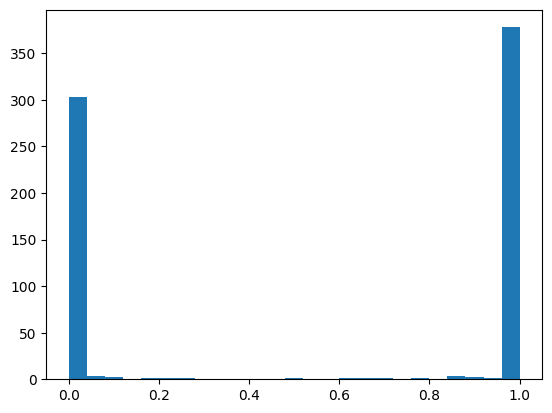

In [34]:
def get_proba(text=str):
    doc = nlp(text)
    return doc.cats['POS']


test = anotados.tokens.tolist()

proba_ls = [*map(get_proba, test)]

anotados['prob'] = proba_ls.copy()

_, bins = pd.cut(proba_ls, bins=25, retbins=True)
plt.hist(proba_ls, bins);

C:\Users\juani\AppData\Local\Temp\ipykernel_25528\1592397077.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anotados['pred'] = discretize_ls.copy()


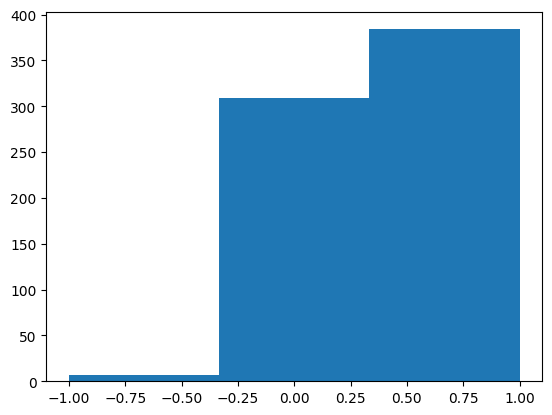

In [36]:
def discretize(p):
    if p<0.2:
        return 0
    elif p<0.8:
        return -1
    else:
        return 1

discretize_ls = [*map(discretize, proba_ls)]
anotados['pred'] = discretize_ls.copy()
_, bins = pd.cut(discretize_ls, bins=3, retbins=True)
plt.hist(discretize_ls, bins);

In [37]:
anotados['control'] = [ int(a==b) for a,b in zip( discretize_ls, anotados.Numbers.tolist())]

C:\Users\juani\AppData\Local\Temp\ipykernel_25528\3258463554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anotados['control'] = [ int(a==b) for a,b in zip( discretize_ls, anotados.Numbers.tolist())]


# EXAMPLE

In [38]:
text = '''
KEYBOARD S.A.
Escritura Nº 362 de fecha 27/06/2023. Orlando DI FONZO, argentino, empresario, casado en primeras nupcias con 
Amalia Rinaldi, DNI 8.609.671, CUIT Nº 20-08609671-5; y Gonzalo Gastón DI FONZO, argentino, empresario, soltero, 
DNI 33.689.504, CUIT 23-33689504-9, ambos domiciliados en Carmen Puch Nº 1000, de la Localidad y Partido de 
Pilar, Provincia de Buenos Aires: Resuelven que la sociedad se adecúe voluntariamente a las disposiciones del art. 
124 de la ley 19.550 y aprueban todas las estipulaciones del estatuto: 1) Keyboard S.A. 2) Duración: 30 años desde 
inscripción. 3) Objeto: Compra, venta, hipoteca, arrendamiento y toda clase de operaciones con bienes inmuebles. 
Realizar y/o administrar inversiones. Importaciones, exportaciones, comisiones, representaciones y mandatos. 
Operaciones financieras relacionadas con sus actividades principales. 4) Capital: $  1.000.000.-, representado 
por diez mil acciones ordinarias, nominativas no endosables, de v/n $ 100.- cada una y derecho a un voto por 
acción. 5) Dirección y administración: a cargo del directorio compuesto del número de miembros que determine 
la asamblea, entre un mínimo de uno y un máximo de cinco, por tres ejercicios. 6) Prescindencia de Sindicatura. 
7) Suscripción: Orlando DI FONZO y Gonzalo Gastón DI FONZO suscriben la cantidad de cinco mil acciones 
cada uno, lo que representa el 50% del capital social. Directorio: PRESIDENTE: Orlando DI FONZO; y DIRECTOR 
SUPLENTE: Gonzalo Gastón DI FONZO, quienes constituyen domicilio especial en la sede social, fijada en la calle 
Lavalle Nº 643, Piso 5º, Oficina “D”, C.A.B.A. Cierre ejercicio social: 30 de junio de cada año. Autorizado según 
instrumento público Esc. Nº 362 de fecha 27/06/2023 Reg. Nº 1017.
Lucía Agundez - T°: 114 F°: 540 C.P.A.C.F.
'''

In [39]:
doc = nlp(text)
print(doc.cats['POS'])

0.9994329810142517


In [42]:
text_2 = '''
GRUPO LAS NACIONES S.A.S.
CONSTITUCIÓN: 18/09/2019. 1.- PABLO BARBERO, 01/04/1987, Casado/a, Argentina, VENTA AL POR MENOR 
NO REALIZADA EN ESTABLECIMIENTOS N.C.P., PERU 1087 piso -- CIUDAD DE BUENOS AIRES, DNI 
Nº 32629804, CUIL/CUIT/CDI Nº 20326298043, DARIO BARBERO, 25/09/1963, Casado/a, Argentina, SERVICIOS 
DE CONTABILIDAD, AUDITORÍA Y ASESORÍA FISCAL, PERU 1087 piso -- CIUDAD DE BUENOS AIRES, DNI 
Nº 16432964, CUIL/CUIT/CDI Nº 20164329640, . 2.- “Grupo Las Naciones SAS”. 3.- PERU 1087 piso --, CABA. 4.- 
La sociedad tiene por objeto dedicarse, por cuenta propia o ajena o asociada con terceros, ya sea dentro o fuera 
del país, a la creación, producción, intercambio, fabricación, transformación, industrialización, comercialización, 
intermediación, representación, importación y exportación de toda clase de bienes materiales, incluso recursos 
naturales, e inmateriales y la prestación de toda clase de servicios, relacionados directa o indirectamente con 
las siguientes actividades: (a) Agropecuarias, avícolas, ganaderas, pesqueras, tamberas y vitivinícolas; (b) 
Comunicaciones, espectáculos, editoriales y gráficas en cualquier soporte; (c) Industrias manufactureras de 
todo tipo; (d) Culturales y educativas; (e) Desarrollo de tecnologías, investigación e innovación y software; (f) 
Gastronómicas, hoteleras y turísticas; (g) Inmobiliarias y constructoras; (h) Inversoras, financieras y fideicomisos; (i) 
Petroleras, gasíferas, forestales, mineras y energéticas en todas sus formas; (j) Salud, y (k) Transporte. La sociedad 
tiene plena capacidad de derecho para realizar cualquier acto jurídico en el país o en el extranjero, realizar toda 
actividad lícita, adquirir derechos y contraer obligaciones. Para la ejecución de las actividades enumeradas en su 
objeto, la sociedad puede realizar inversiones y aportes de capitales a personas humanas y/o jurídicas, actuar como 
fiduciario y celebrar contratos de colaboración; comprar, vender y/o permutar toda clase de títulos y valores; tomar 
y otorgar créditos y realizar toda clase de operaciones financieras, excluidas las reguladas por la Ley de Entidades 
Financieras y toda otra que requiera el concurso y/o ahorro público.. 5.- 99 años. 6.- $ 31250. 7.- Administrador 
titular: PABLO BARBERO con domicilio especial en Argentina, Ciudad de Buenos Aires, Ciudad de Buenos Aires, 
PERU 1087 piso --, CPA 1068 , Administrador suplente: DARIO BARBERO, con domicilio especial en Argentina, 
Ciudad de Buenos Aires, Ciudad de Buenos Aires, PERU 1087 piso --, CPA 1068; todos por plazo de 99 años . 
8.- Prescinde del órgano de fiscalización Fiscalizador titular: ; ; . 9.- 31 de Diciembre de cada año.
Trámites a Distancia, Delegación Administrativa, Inspección General de Justicia
'''
doc = nlp(text_2)
print(doc.cats['POS'])

0.9978819489479065
